In [64]:
# Brightway imports
import bw2analyzer as ba
import bw2calc as bc
import bw2data as bd
import bw2io as bi
import brightway2 as bw
from bw2data import parameters
from sympy.physics.units import years
from sympy.stats.crv_types import LogNormalDistribution
from sympy import init_printing
import lca_algebraic as agb
from dotenv import load_dotenv

# Custom utils defined for the parameterization
from lca_algebraic import *
from lca_algebraic.stats import *

# Pretty print for Sympy
init_printing()

In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm, lognorm, expon, beta, uniform, triang, kstest

In [66]:
BW_PROJECT = 'lca-alg-2' # insert your project name here
bd.projects.set_current(BW_PROJECT)

EI_DB = 'ecoinvent-3.9.1-cutoff' # name of ecoinvent database in your project
# We use a separate DB for defining our foreground model / activities
USER_DB = "MyForeground"

In [67]:
# This is better to cleanup the whole foreground model each time, and redefine it in the notebook (or a python file)
# instead of relying on a state or previous run.
# Any persistent state is prone to errors.
agb.resetDb(USER_DB)

# Parameters are stored at project level : 
# Reset them also
# You may remove this line if you import a project and parameters from an external source (see loadParam(..))
agb.resetParams()

# Overview of the databases
agb.list_databases()

[WARNING] Db MyForeground was here. Reseting it


,backend,nb_activities,type
name,,,
biosphere3,sqlite,4718,biosphere
ecoinvent-3.9.1-cutoff,sqlite,21238,background
MyForeground,sqlite,0,foreground


# Initial data exploration
## Ore grade

### Load an plot distributions

In [68]:
df_nickel = pd.read_excel(r'data/data_metals_pellan.xlsx', sheet_name='Mudd2014_ni')
df_copper = pd.read_excel(r'data/data_metals_pellan.xlsx', sheet_name='Mudd2018_cop')

In [69]:
def plot_grade_statistics(df, grade_column, mineral, country=None):
    """
    Plots two subplots: (1) a histogram of ore grade data and (2) a KDE distribution with key statistics
    for a specific mineral. Returns a summary DataFrame with mean, min, max, and standard deviation.

    Parameters:
    - df (pd.DataFrame): The dataset containing ore grade data.
    - grade_column (str): The column name for ore grade values.
    - mineral (str): The mineral name (e.g., "Nickel" or "Copper").
    - country (str, optional): Specific country to filter the data by. Defaults to "All" if None.

    Returns:
    - pd.DataFrame: Summary of statistics including Mean, Min, Max, and Std Dev for the selected grade column.
    """
    # Filter by country if specified
    if country:
        df = df[df['Country'] == country]
    else:
        country = "All"  # Set country to "All" if no specific country is provided
    
    # Calculate statistics
    mean_val = df[grade_column].mean()
    min_val = df[grade_column].min()
    max_val = df[grade_column].max()
    std_dev = df[grade_column].std()

    # Set up subplots
    fig, axes = plt.subplots(1, 2, figsize=(15, 6), gridspec_kw={'width_ratios': [1, 1.2]})

    # Plot histogram on the first subplot
    sns.histplot(df[grade_column], kde=False, color='lightgrey', bins=15, stat='count', ax=axes[0])
    axes[0].set_title(f'{mineral} - {grade_column} Histogram' + (f' for {country}' if country else ''))
    axes[0].set_xlabel(grade_column)
    axes[0].set_ylabel('Count')

    # Plot KDE on the second subplot with key statistics
    sns.kdeplot(df[grade_column], fill=True, color='skyblue', ax=axes[1], label="KDE", linewidth=2, clip=(min_val, max_val))
    axes[1].axvline(mean_val, color='green', linestyle='--', label=f'Mean: {mean_val:.4f}')
    axes[1].axvline(min_val, color='blue', linestyle='--', label=f'Min: {min_val:.4f}')
    axes[1].axvline(max_val, color='red', linestyle='--', label=f'Max: {max_val:.4f}')
    axes[1].axvline(mean_val + std_dev, color='purple', linestyle=':', label=f'Mean + Std Dev: {(mean_val + std_dev):.4f}')
    axes[1].axvline(mean_val - std_dev, color='purple', linestyle=':', label=f'Mean - Std Dev: {(mean_val - std_dev):.4f}')
    axes[1].set_title(f'{mineral} - {grade_column} KDE Distribution' + (f' for {country}' if country else ''))
    axes[1].set_xlabel(grade_column)
    axes[1].set_ylabel('Density')
    axes[1].legend()

    plt.tight_layout()
    plt.show()
    
    # Return summary statistics in a DataFrame
    summary_df = pd.DataFrame({
        'Mineral': [mineral],
        'Grade Column': [grade_column],
        'Country': [country],
        'Mean': [mean_val],
        'Min': [min_val],
        'Max': [max_val],
        'Std Dev': [std_dev]
    })
    
    return summary_df

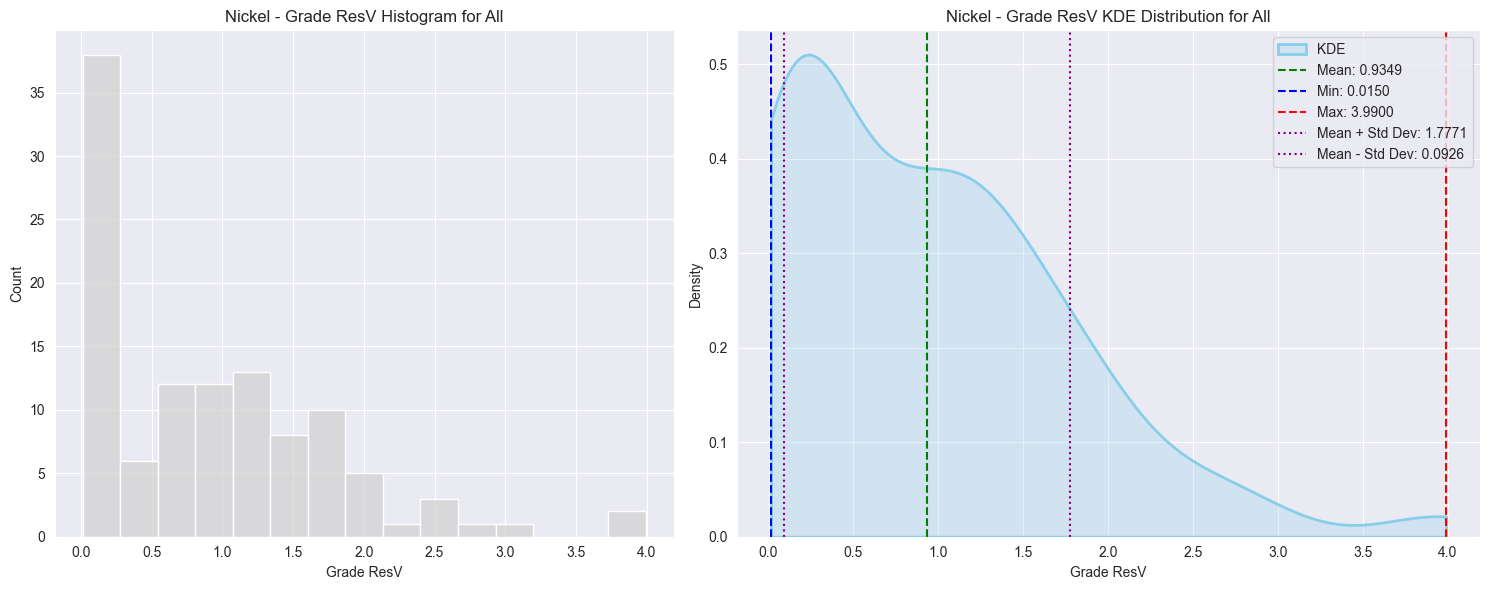

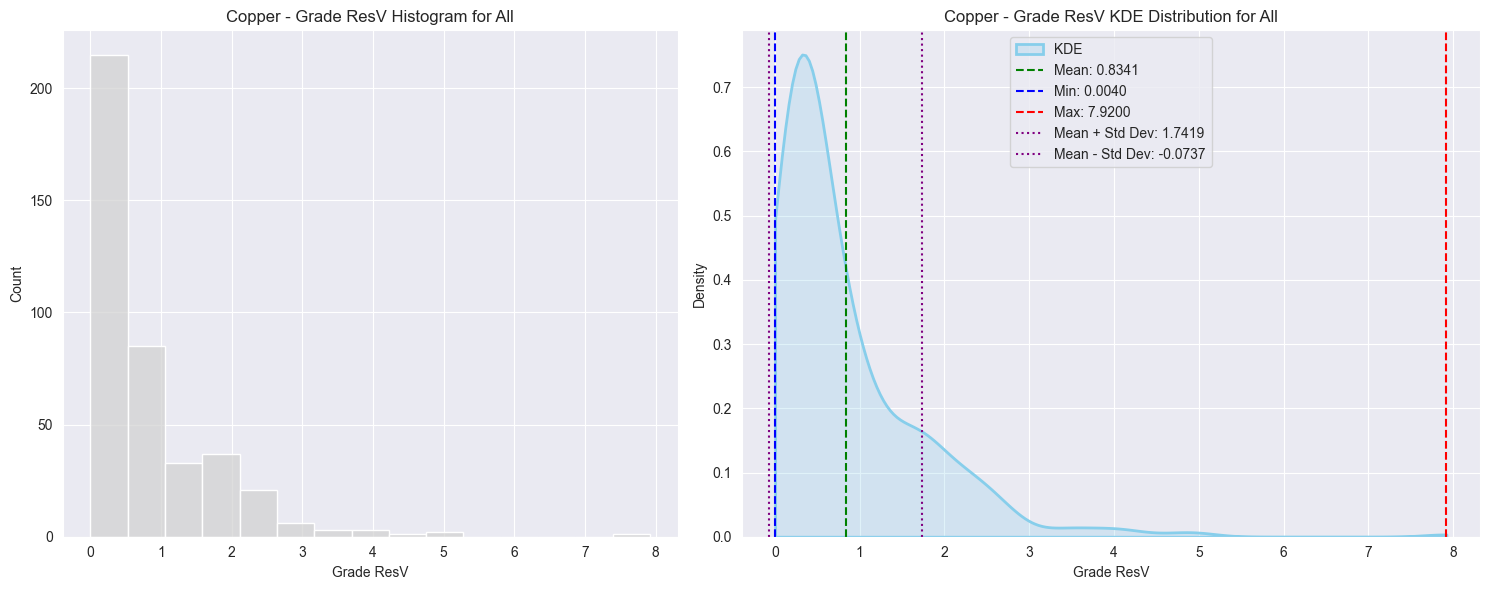

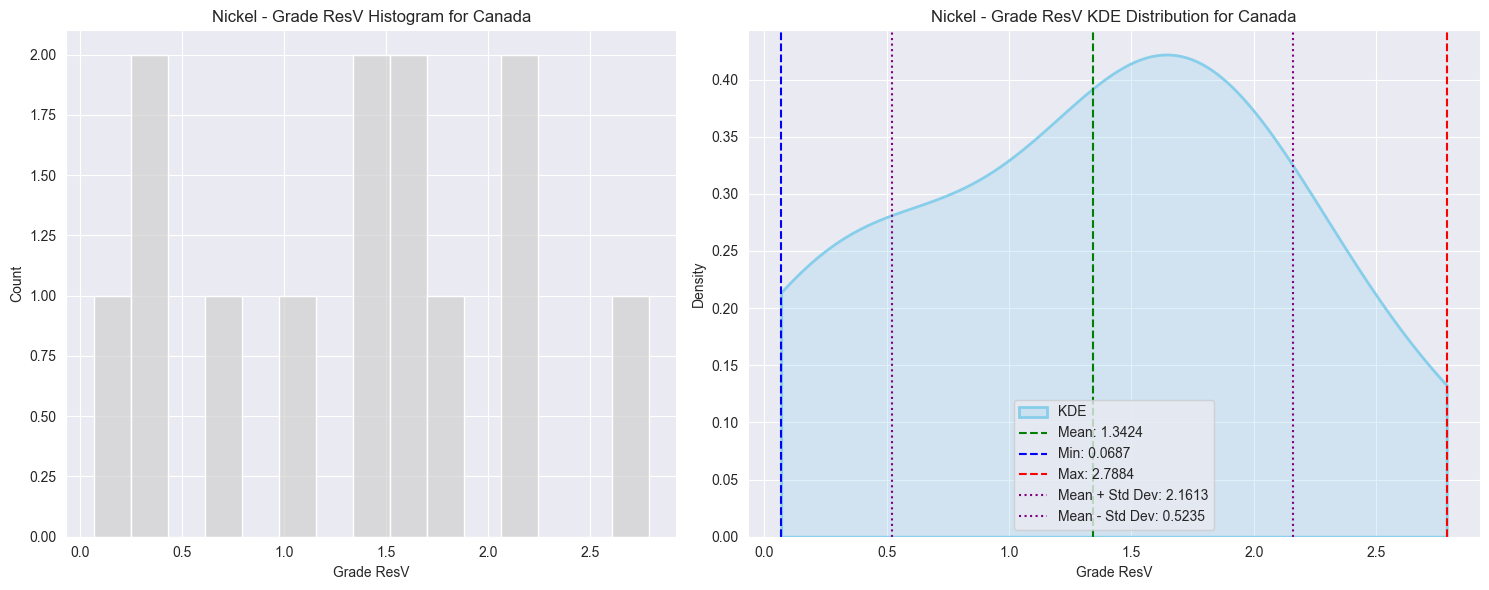

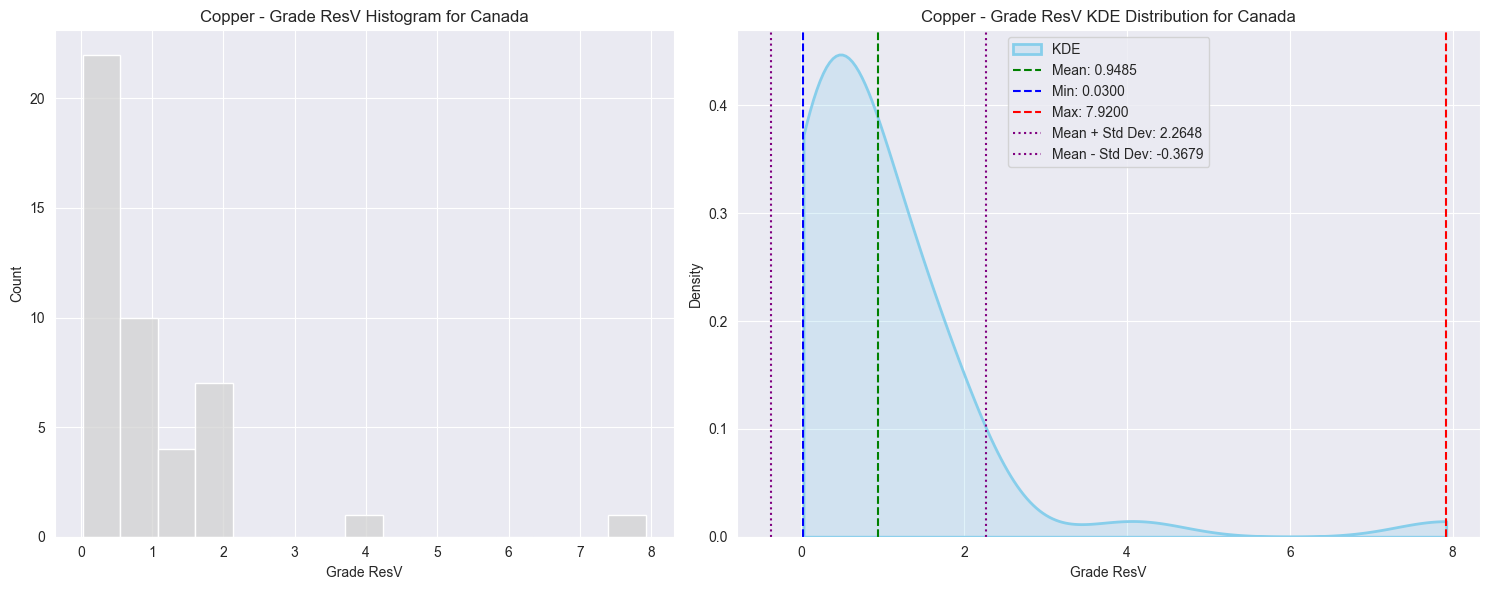

,Mineral,Grade Column,Country,Mean,Min,Max,Std Dev
0,Nickel,Grade ResV,All,0.934864,0.015,3.99003,0.842238
1,Copper,Grade ResV,All,0.834055,0.004,7.92,0.907797
2,Nickel,Grade ResV,Canada,1.3424,0.0687193,2.78839,0.818872
3,Copper,Grade ResV,Canada,0.948472,0.03,7.92,1.31636


In [70]:
# Using the function for Nickel and Copper grades for all regions and Canada
nickel_resv = plot_grade_statistics(df_nickel, 'Grade ResV', 'Nickel')
copper_resv = plot_grade_statistics(df_copper, 'Grade ResV', 'Copper')
nickel_resv_can = plot_grade_statistics(df_nickel, 'Grade ResV', 'Nickel', country='Canada')
copper_resv_can = plot_grade_statistics(df_copper, 'Grade ResV', 'Copper', country='Canada')

# Concatenate dfs
og_stat = pd.concat([nickel_resv, copper_resv, nickel_resv_can,copper_resv_can ], ignore_index=True)

# Display the concatenated summary DataFrame
og_stat


In [71]:
# Storing each row in a dictionary for easy retrieval by mineral and region
ore_grade_stats = {}
for _, row in og_stat.iterrows():
    mineral = row['Mineral']
    region = row['Country']
    
    # Initialize dictionary for each mineral if not already present
    if mineral not in ore_grade_stats:
        ore_grade_stats[mineral] = {}
    
    # Store values for each region under the mineral key
    ore_grade_stats[mineral][region] = {
        'Mean': row['Mean'],
        'Min': row['Min'],
        'Max': row['Max'],
        'Std Dev': row['Std Dev']
    }

In [72]:
# Example usage to access values:
nickel_stats = ore_grade_stats['Nickel']['All']
nickel_stats

{'Mean': 0.9348643824454926,
 'Min': 0.015,
 'Max': 3.990033924698293,
 'Std Dev': 0.8422379199618545}

In [73]:
ni_mean = 0.934864
ni_min = 0.015
ni_max = 3.99003
ni_std = 0.842238

cu_mean = 0.834055
cu_min = 0.004
cu_max = 7.92
cu_std = 0.907797

In [74]:
ni_can_mean = 1.3424
ni_can_min = 0.0687193
ni_can_max = 2.78839
ni_can_std = 0.818872

cu_can_mean = 0.948472
cu_can_min = 0.03
cu_can_max = 7.92
cu_can_std = 1.31636

### Choice of distributions

lca_algebraic supports seven distribution types: 
- Fixed 
- Uniform 
- Triangle
- Normal
- Log-normal
- Beta
- Statistic weight

In [ ]:
def plot_distribution_fits(df, grade_column, mineral, country=None):
    """
    Plots KDE with overlays of different distribution fits to visually assess best fit.
    
    Parameters:
    - df (pd.DataFrame): The dataset containing ore grade data.
    - grade_column (str): The column name for ore grade values.
    - mineral (str): The mineral name (e.g., "Nickel" or "Copper").
    - country (str, optional): Specific country to filter the data by.
    
    Returns:
    - None, shows the plot.
    """
    # Filter data by country if specified
    if country:
        df = df[df['Country'] == country]
    
    data = df[grade_column].dropna()
    mean_val, std_dev = data.mean(), data.std()
    min_val, max_val = data.min(), data.max()
    x_values = np.linspace(min_val, max_val, 100)

    # Plot KDE, restricted to valid range using clip
    plt.figure(figsize=(10, 6))
    sns.kdeplot(data, fill=True, color='skyblue', label="KDE", linewidth=2, clip=(min_val, max_val))

    # Overlay normal distribution
    norm_pdf = norm.pdf(x_values, mean_val, std_dev)
    plt.plot(x_values, norm_pdf, 'green', linestyle='--', label="Normal")

    # Overlay log-normal distribution
    if mean_val > 0 and std_dev > 0:  # Ensure positive values for log-normal
        shape, loc, scale = lognorm.fit(data, floc=0)
        lognorm_pdf = lognorm.pdf(x_values, shape, loc=loc, scale=scale)
        plt.plot(x_values, lognorm_pdf, 'orange', linestyle='--', label="Log-normal")

    # Overlay uniform distribution
    uniform_pdf = uniform.pdf(x_values, loc=min_val, scale=(max_val - min_val))
    plt.plot(x_values, uniform_pdf, 'purple', linestyle='--', label="Uniform")

    # Overlay triangular distribution
    c = (mean_val - min_val) / (max_val - min_val) if max_val != min_val else 0.5
    triang_pdf = triang.pdf(x_values, c, loc=min_val, scale=(max_val - min_val))
    plt.plot(x_values, triang_pdf, 'blue', linestyle='--', label="Triangular")

    # Overlay beta distribution
    try:
        a, b, loc, scale = beta.fit(data, floc=min_val, fscale=(max_val - min_val))
        beta_pdf = beta.pdf(x_values, a, b, loc=loc, scale=scale)
        plt.plot(x_values, beta_pdf, 'red', linestyle='--', label="Beta")
    except ValueError:
        print("Beta distribution fitting failed due to data range constraints.")

    # Titles and labels
    plt.title(f'{mineral} - {grade_column} KDE with Distribution Fits' + (f' for {country}' if country else ''))
    plt.xlabel(grade_column)
    plt.ylabel('Density')
    plt.legend()
    plt.show()



In [ ]:
plot_distribution_fits(df_nickel, 'Grade ResV', 'Nickel')
plot_distribution_fits(df_copper, 'Grade ResV', 'Copper')
plot_distribution_fits(df_nickel, 'Grade ResV', 'Nickel', country='Canada')
plot_distribution_fits(df_copper, 'Grade ResV', 'Copper', country='Canada')


In [ ]:
# Adjust the function to skip beta fitting if data does not meet the requirement
def fit_and_test_distributions(df, grade_column, country=None, mineral=None):
    """
    Fits multiple theoretical distributions to the given ore grade data, 
    visualizes the data with a histogram and overlaid distribution curves, 
    and performs a Kolmogorov-Smirnov (K-S) test to assess the goodness of fit.

    Parameters:
    - df (pd.DataFrame): The dataset containing ore grade data.
    - grade_column (str): The column name for ore grade values.
    - country (str, optional): Specific country to filter the data by. If None, uses all data.

    Returns:
    - results (dict): A dictionary of K-S test results for each distribution, containing:
        - 'Statistic': The maximum difference between the empirical and theoretical cumulative distributions.
        - 'P-value': The probability that the sample data comes from the tested distribution.
        
    Notes:
    - Distributions tested include normal, log-normal, triangular, uniform, and beta (if data is within bounds).
    - Lower statistics and higher p-values indicate a better fit between the data and the tested distribution.
    """
     
    # Filter by country if specified
    if country:
        df = df[df['Country'] == country]
    
    # Drop NaN values and check if data is empty
    data = df[grade_column].dropna()
    if data.empty:
        print(f"No data available for {grade_column} in {country if country else 'all countries'}")
        return None
    
    # Plot histogram
    plt.figure(figsize=(10, 6))
    plt.hist(data, bins=10, density=True, alpha=0.6, color='blue', label="Histogram")

    # Fit and plot normal distribution
    mu, std = norm.fit(data)
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    p_norm = norm.pdf(x, mu, std)
    plt.plot(x, p_norm, 'r-', label="Normal fit")

    # Fit and plot log-normal distribution
    shape, loc, scale = lognorm.fit(data, floc=0)
    p_lognorm = lognorm.pdf(x, shape, loc, scale)
    plt.plot(x, p_lognorm, 'g-', label="Log-normal fit")

    # Fit and plot triangular distribution
    min_val, max_val = data.min(), data.max()
    most_likely = data.mean()  # Typically mean or mode for triangular
    c = (most_likely - min_val) / (max_val - min_val) if max_val != min_val else 0.5
    p_triang = triang.pdf(x, c, loc=min_val, scale=(max_val - min_val))
    plt.plot(x, p_triang, 'b-', label="Triangular fit")

    # Fit and plot uniform distribution
    p_uniform = uniform.pdf(x, loc=min_val, scale=max_val - min_val)
    plt.plot(x, p_uniform, 'm-', label="Uniform fit")

    # Store K-S test results for valid distributions
    results = {
        'Normal': kstest(data, 'norm', args=(mu, std)),
        'Log-normal': kstest(data, 'lognorm', args=(shape, loc, scale)),
        'Triangular': kstest(data, 'triang', args=(c, min_val, max_val - min_val)),
        'Uniform': kstest(data, 'uniform', args=(min_val, max_val - min_val))
    }

    # Attempt Beta fit, skip if data is outside 0-1 range after scaling
    try:
        a, b, loc, scale = beta.fit(data, floc=min_val, fscale=max_val - min_val)
        p_beta = beta.pdf(x, a, b, loc, scale)
        plt.plot(x, p_beta, 'y-', label="Beta fit")
        results['Beta'] = kstest(data, 'beta', args=(a, b, loc, scale))
    except ValueError:
        print(f"Skipping Beta fit for {grade_column} in {country if country else 'all countries'} (data out of bounds)")

    plt.title(f'{mineral} {grade_column} Distribution Fit' + (f' for {country}' if country else ''))
    plt.xlabel(grade_column)
    plt.ylabel('Density')
    plt.legend()
    plt.show()

    return results

In [ ]:
# Helper function to convert K-S test results into a DataFrame for easier analysis
def extract_results_to_df(results, mineral, grade_column, country=None):
    extracted_data = []
    for dist_name, result in results.items():
        extracted_data.append({
            'Mineral': mineral,
            'Grade Column': grade_column,
            'Country': country if country else 'All',
            'Distribution': dist_name,
            'Statistic': result.statistic,
            'P-value': result.pvalue
        })
    return pd.DataFrame(extracted_data)

In [ ]:
distrib_nickel_resv = fit_and_test_distributions(df_nickel, 'Grade ResV', mineral='Nickel')
distrib_copper_resv = fit_and_test_distributions(df_copper, 'Grade ResV', mineral='Copper')
distrib_nickel_resv_can = fit_and_test_distributions(df_nickel, 'Grade ResV', country="Canada", mineral='Nickel')
distrib_copper_resv_can = fit_and_test_distributions(df_copper, 'Grade ResV', country="Canada", mineral='Copper')

# Collect all results into DataFrames if results exist
results_dfs = []
if distrib_nickel_resv: results_dfs.append(extract_results_to_df(distrib_nickel_resv, 'Nickel', 'Grade ResV'))
if distrib_copper_resv: results_dfs.append(extract_results_to_df(distrib_copper_resv, 'Copper', 'Grade ResV'))
if distrib_nickel_resv_can: results_dfs.append(extract_results_to_df(distrib_nickel_resv_can, 'Nickel', 'Grade ResV', country='Canada'))
if distrib_copper_resv_can: results_dfs.append(extract_results_to_df(distrib_copper_resv_can, 'Copper', 'Grade ResV', country='Canada'))

# Combine all results into a single DataFrame
df_all_ks_test_results = pd.concat(results_dfs, ignore_index=True)
df_all_ks_test_results 

NormalDistribution (nickel) and LogNormalDistribution (copper) appear to be a good fit

In [75]:
# If log-normal distribution is chosen, we need those formulas to calculate the mean and std
cu_mean_log = np.log(cu_mean / np.sqrt(1 + (cu_std / cu_mean) ** 2))
cu_std_log = np.sqrt(np.log(1 + (cu_std / cu_mean) ** 2))

# Defining input parameters for the parametrization

The following parameters are included:

- ore grade
- mining technique mix (open cast, underground, ISL)
- mining depth
- tailings emissions
- mining energy mix 

## Explanation

### Ore grade

Ore grade decline are observed for copper, zinc, lead and nickel in Van der Voet et al (2019). 10.1111/jiec.12722, who takes information from various sources (Mudd et al. (2017), Crowson (2012), Mudd & Jowit (2013), Northey et al. (2014) and Mudd et al. (2013)). 

The energy ore grade relation defines how energy inputs change as a function of the
ore grade. Instead of developing a function for each individual input and output, the energy change often serve as a proxy for the change of other inputs
and outputs. 

Thus, we model the effects of ore grade decline on the mining process
by applying the percentage energy change to all other input and output values. The only process affected by an ore grade decline is the metal mine operation.

- 1 - Definition of future ore grades G(t) and G(t0) for base years
- 2 - Definition of energy requirements E(G) based on the energy-ore relation from literature
- 3 - Calculate a percentage change p(t) between the base year and the future years
- 4 - Calculate modelling factor, which is applied to outflows of mining processes in ecoivent to model how inputs and outputs of mining processes change

- 1 - We first use a distribution to generate a set of possible ore grades. This distribution reflects uncertainty in the ore grade parameters
- 2 - We calculate the energy requirement for each sample based on the ore grade - energy requirement for each sample

In [ ]:
## Mining technique mix

In [ ]:
## Mining depth

In [ ]:
## Mining energy mix

## Defining distributions for input parameters

lca_algebraic supports seven distribution types: 
- Fixed 
- Uniform 
- Triangle
- Normal
- Log-normal
- Beta
- Statistic weight

In [100]:
# Float parameters 
og_cu_world = newFloatParam(
    'ore_grade_copper', 
    default=cu_mean,
    std= cu_std,
    min=cu_min,
    max=cu_max,
    unit='dimensionless',
    distrib=DistributionType.NORMAL,
    description="From statistical analysis of ore grade data from Mudd et al (2018)",
    label="Copper ore grade",
    dbname=USER_DB, 
    save=False #By default, new parameters are kept in memory but also persisted in the project (unless save=False)
)

og_ni_world = newFloatParam(
    'ore_grade_nickel', 
    default=ni_mean,
    std= ni_std,
    min=ni_min,
    max=ni_max,
    unit='dimensionless',
    distrib=DistributionType.NORMAL,
    description="From statistical analysis of ore grade data from Mudd et al (2014)",
    label="Nickel ore grade",
    dbname=USER_DB, 
    save=False #By default, new parameters are kept in memory but also persisted in the project (unless save=False)
)

[WARNING] [ParamRegistry] Param ore_grade_copper was already defined in 'MyForeground' : overriding.
[WARNING] [ParamRegistry] Param ore_grade_nickel was already defined in 'MyForeground' : overriding.


In [ ]:
mining_tech_mix = {'open_pit':.161/.935,
                'underground':.200/.935,
                'ISL':0.574/.935}

In [ ]:
mining_energy_mix = {'diesel':0.3,
                        'electricity':0.7}

In [ ]:
mining_electricity_switch = newEnumParam(
    'mining_electricity_switch', 
    label='Mining electricity, grid or diesel',
    values=['dieselgenerator',
            'grid'], # You can provide a statistical weight for each value, by using a dict
    default='dieselgenerator', 
    description="Choice of electricity source for mining",
    dbname=USER_DB)

In [ ]:
# Emissions of radon-222 from tailings
tailings_Rn222 = newFloatParam(
    'tailings_Rn222', 
    default=0.01951, min=0.01, max=1,
    distrib=DistributionType.TRIANGLE, # Distribution type, linear by default
    description="Rn222 from tailings, in Bq/s",
    label="Rn222 from tailings, in Bq/s",
    unit='Bq/s',
    dbname=USER_DB)

In [ ]:
# Conversion phase, heat consumption
conversion_heat = newFloatParam(
    'conversion_heat', 
    default=26, min=26, max=665,
    distrib=DistributionType.TRIANGLE,
    label='Conversion heat input',
    unit='kWh/kg U in UF6',
    description="Heat required to convert 1 kg of UF6",
    dbname=USER_DB)

In [77]:
list_parameters() # recap of all parameters declared in the model 

group,name,label,default,min,max,std,distrib,unit,db
,ore_grade_copper,Copper ore grade,0.834055,0.004,7.92,0.883998,lognormal,dimensionless,MyForeground
,ore_grade_nickel,Nickel ore grade,0.934864,0.015,3.99003,0.842238,normal,dimensionless,MyForeground


## Functions to link the input parameters to elements in the LCI

Here we can put the relation between energy and ore grade

In [101]:
def energy_ore_grade(ore_grade, r, q):
    """
    Calculate the energy requirement based on ore grade.

    Parameters:
    - ore_grade (float or np.array): The ore grade value(s), e.g., in percentage or fraction.
    - r (float): Constant for energy-ore grade relation, specific to the metal.
    - q (float): Exponent that defines sensitivity of energy to ore grade changes.

    Returns:
    - float or np.array: Energy requirement (MJ/kg) based on ore grade.
    """
    return r * np.power(ore_grade, q)

In [102]:
#From Kuipers et al (2016)
r = 15.63
q = -0.53

In [103]:
og_cu_world

In [81]:
# Calculate updated energy demand based on ore grade
updated_energy = energy_ore_grade(og_cu_world, r, q)

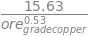

In [82]:
updated_energy

# Transforming and updating parametrized inventories

We need different activities for the different parameters. For example:
    
- An open pit and underground activities for the mining technique mix 
- A diesel machinery and generator
- An electricity grid
- ...

In [ ]:
#copper = [act for act in bd.Database(EI_DB) if
#                     act['name'] == "copper mine operation and beneficiation, sulfide ore" and act['location'] == "CA"][
#    0]
#copper.key


In [104]:
# Don't know why it finds several activities, so we take the code
copper = findActivity(code='9d722cc3f3dc5522d98392a44fc244b9', loc='CA', db_name=EI_DB)

In [105]:
# Copy to preserve the non-parametrized inventories 
copper_p = copyActivity(
    USER_DB,
    copper,
    'copper mine operation and beneficiation, sulfide ore, parameterized')

[WARNING] Activity 'copper mine operation and beneficiation, sulfide ore, parameterized' was already in 'MyForeground'. Overwriting it


In [106]:
# list of activities and exchanges, e.g. biosphere and technosphere flows
agb.printAct(copper_p) 

copper mine operation and beneficiation, sulfide ore, parameterized[CA] (1.000000 kilogram)  \
                                                                                                                                    input   
Aluminium III                                                                      Aluminium III                                            
Antimony ion                                                                        Antimony ion                                            
Arsenic ion                                                                          Arsenic ion                                            
Arsenic ion#1                                                                        Arsenic ion                                            
BOD5, Biological Oxygen Demand                                    BOD5, Biological Oxygen Demand                                            
...                                                                                          ...                                            
potassium carbonate                                               market for potassium carbonate                                            
sodium cyanide                                                    market for sodium cyanide[RoW]                                            
steel, chromium steel 18/8, hot rolled         market for steel, chromium steel 18/8, hot rolled                                            
sulfidic tailings, from copper mine operation  market for sulfidic tailings, from copper mine...                                            
synthetic rubber                                                     market for synthetic rubber                                            

                                                                     
                                                   amount      unit  
Aluminium III                                 1.41043e-06  kilogram  
Antimony ion                                  8.39083e-09  kilogram  
Arsenic ion                                   6.29312e-08  kilogram  
Arsenic ion#1                                 4.81744e-08  kilogram  
BOD5, Biological Oxygen Demand                0.000170116  kilogram  
...                                                   ...       ...  
potassium carbonate                            2.2227e-09  kilogram  
sodium cyanide                                 0.00176916  kilogram  
steel, chromium steel 18/8, hot rolled          0.0664595  kilogram  
sulfidic tailings, from copper mine operation    -90.2164  kilogram  
synthetic rubber                              5.18123e-07  kilogram  

[83 rows x 3 columns]

In [107]:
# Update selected technosphere flow, it is the product name
copper_p.updateExchanges({
    "electricity, high voltage": 15.63*og_cu_world**-0.53
})

In [108]:
agb.printAct(copper_p) 

copper mine operation and beneficiation, sulfide ore, parameterized[CA] (1.000000 kilogram)  \
                                                                                                                                    input   
Aluminium III                                                                      Aluminium III                                            
Antimony ion                                                                        Antimony ion                                            
Arsenic ion                                                                          Arsenic ion                                            
Arsenic ion#1                                                                        Arsenic ion                                            
BOD5, Biological Oxygen Demand                                    BOD5, Biological Oxygen Demand                                            
...                                                                                          ...                                            
potassium carbonate                                               market for potassium carbonate                                            
sodium cyanide                                                    market for sodium cyanide[RoW]                                            
steel, chromium steel 18/8, hot rolled         market for steel, chromium steel 18/8, hot rolled                                            
sulfidic tailings, from copper mine operation  market for sulfidic tailings, from copper mine...                                            
synthetic rubber                                                     market for synthetic rubber                                            

                                                                     
                                                   amount      unit  
Aluminium III                                 1.41043e-06  kilogram  
Antimony ion                                  8.39083e-09  kilogram  
Arsenic ion                                   6.29312e-08  kilogram  
Arsenic ion#1                                 4.81744e-08  kilogram  
BOD5, Biological Oxygen Demand                0.000170116  kilogram  
...                                                   ...       ...  
potassium carbonate                            2.2227e-09  kilogram  
sodium cyanide                                 0.00176916  kilogram  
steel, chromium steel 18/8, hot rolled          0.0664595  kilogram  
sulfidic tailings, from copper mine operation    -90.2164  kilogram  
synthetic rubber                              5.18123e-07  kilogram  

[83 rows x 3 columns]

# Impact calculation

In [109]:
# Don't know why we don't have recent methods
iw_methods = [method for method in bd.methods if "world" in " ".join(method).lower()]
iw_methods

In [110]:
# List of impacts to consider
impacts = agb.findMethods('climate change', mainCat="EF v3.0")
impacts

[('EF v3.0', 'climate change', 'global warming potential (GWP100)'),
 ('EF v3.0', 'climate change: biogenic', 'global warming potential (GWP100)'),
 ('EF v3.0', 'climate change: fossil', 'global warming potential (GWP100)'),
 ('EF v3.0',
  'climate change: land use and land use change',
  'global warming potential (GWP100)')]

In [111]:
# Definition of FU, which can be parametrized
functional_value = 1

In [112]:
agb.list_databases()

,backend,nb_activities,type
name,,,
biosphere3,sqlite,4718,biosphere
ecoinvent-3.9.1-cutoff,sqlite,21238,background
MyForeground,sqlite,61,foreground


In [113]:
agb.compute_impacts(
    
    # Root activity of our inventory
    copper_p, 
    
    # list of impacts to consider
    impacts, 
    
    # The impacts will be divided by the functional unit
    functional_unit=functional_value,
    
    # Parameters of the model
)

[INFO] Db changed recently, clearing cache expr
[INFO] Db changed recently, clearing cache lcia
[INFO] Required param 'ore_grade_copper' was missing, replacing by default value : 0.834055
[INFO] Required param 'ore_grade_copper' was missing, replacing by default value : 0.834055
[INFO] Required param 'ore_grade_copper' was missing, replacing by default value : 0.834055
[INFO] Required param 'ore_grade_copper' was missing, replacing by default value : 0.834055


,climate change - global warming potential (GWP100)[kg CO2-Eq],climate change: biogenic - global warming potential (GWP100)[kg CO2-Eq],climate change: fossil - global warming potential (GWP100)[kg CO2-Eq],climate change: land use and land use change - global warming potential (GWP100)[kg CO2-Eq]
"copper mine operation and beneficiation, sulfide ore, parameterized[CA]",4.27801,0.0330981,4.0682,0.176716


## OAT sensitivity analysis

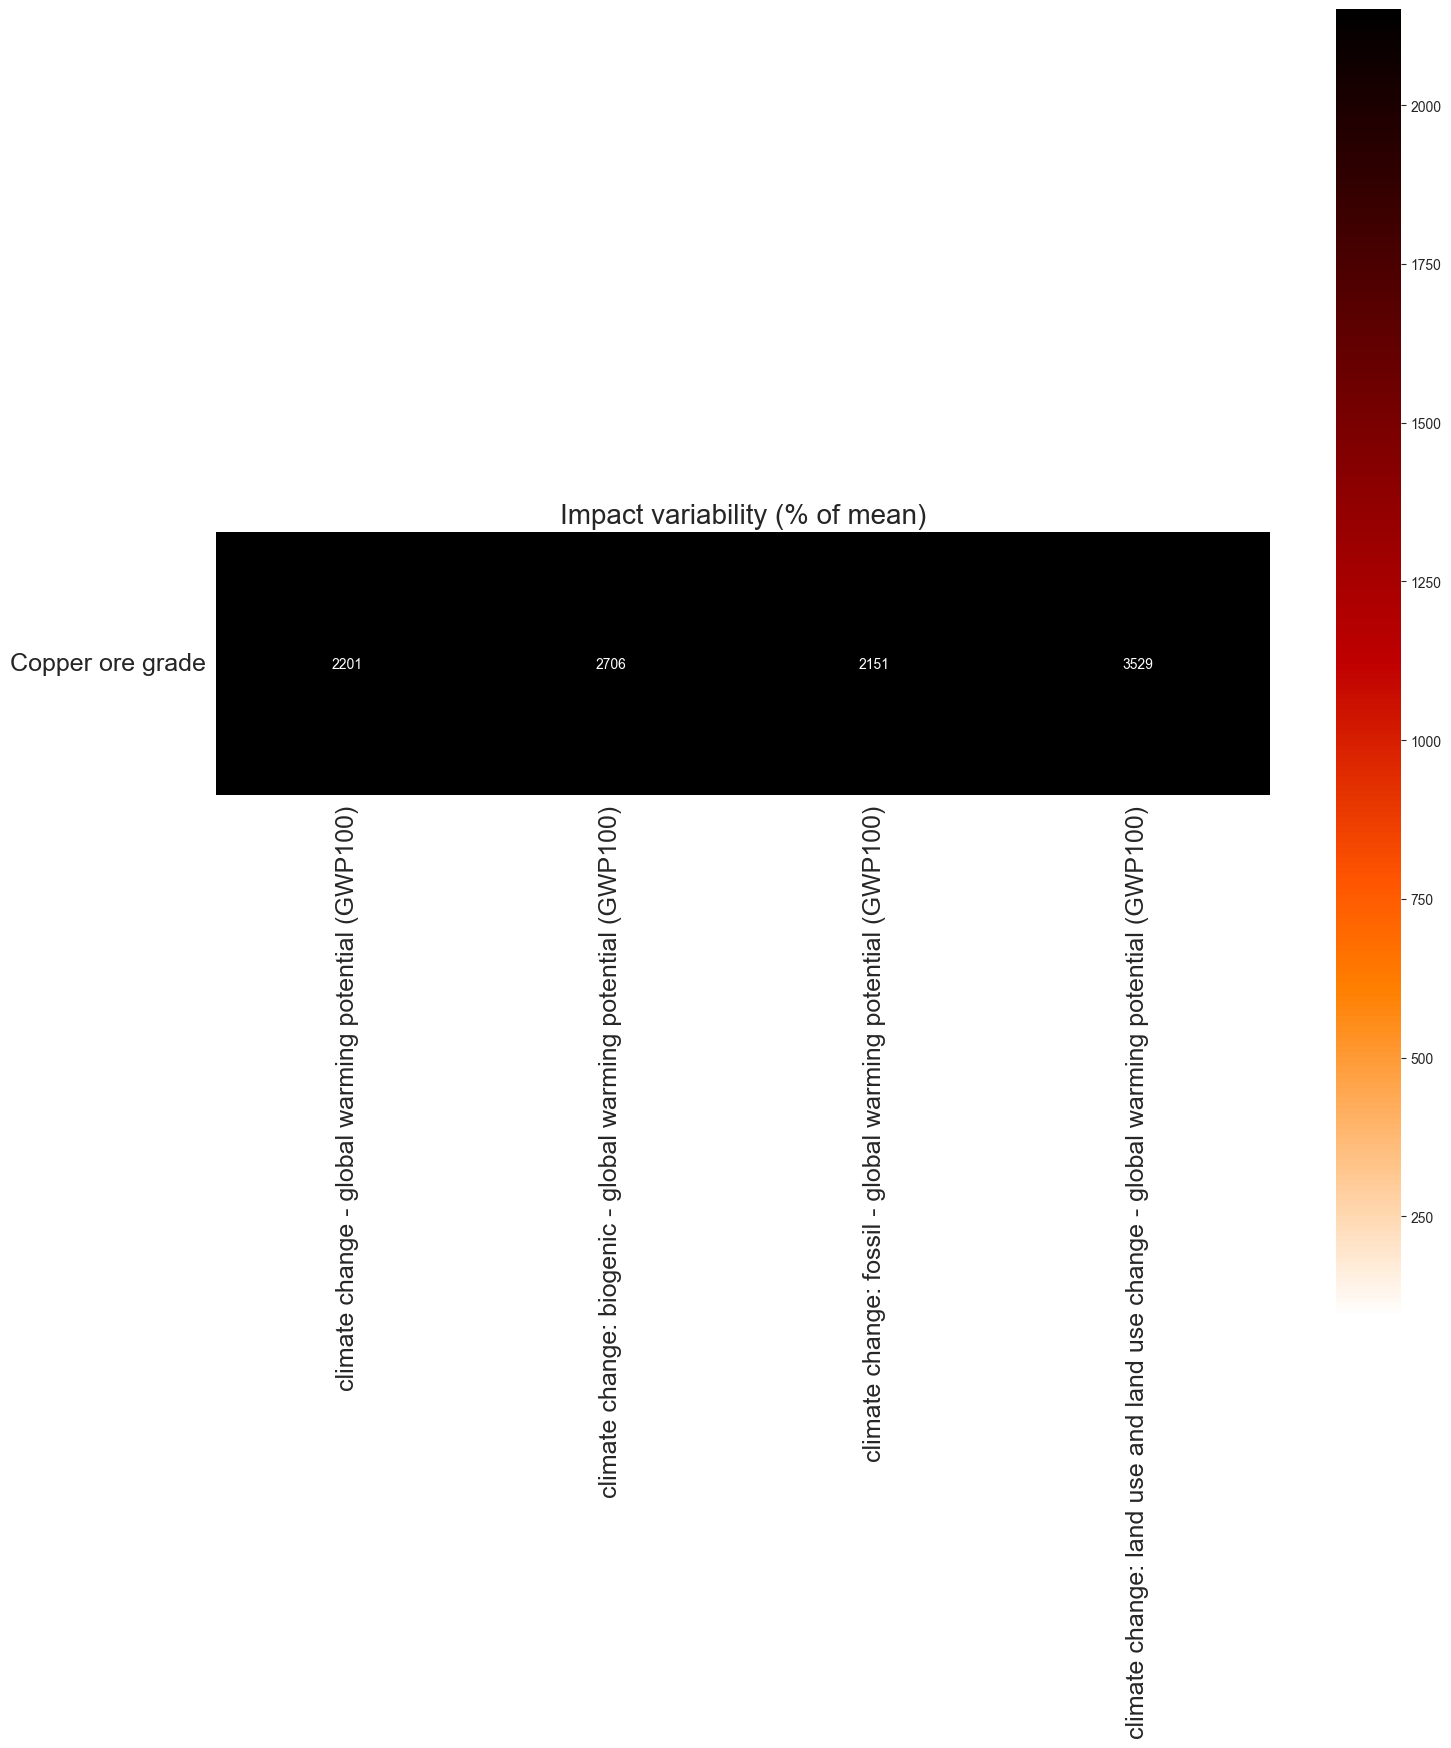

In [114]:
agb.oat_matrix(
    copper_p, 
    impacts, 
    functional_unit=functional_value)

In [115]:
agb.oat_dashboard(
    copper_p, 
    impacts, 
    functional_unit=functional_value,
    
    # Optionnal layout parameters
    figspace=(0.5,0.5),
    figsize=(15, 15),
    sharex=True)

interactive(children=(Dropdown(description='param', options=('ore_grade_copper',), value='ore_grade_copper'), …

## GSA

In [117]:
# Show sobol indices 
agb.incer_stochastic_matrix(
    copper_p, 
    impacts, 
    functional_unit=functional_value)

Generating samples ...
Transforming samples ...
Processing Sobol indices ...
Processing sobol for ('EF v3.0', 'climate change', 'global warming potential (GWP100)')
Processing sobol for ('EF v3.0', 'climate change: biogenic', 'global warming potential (GWP100)')
Processing sobol for ('EF v3.0', 'climate change: fossil', 'global warming potential (GWP100)')
Processing sobol for ('EF v3.0', 'climate change: land use and land use change', 'global warming potential (GWP100)')


C:\Users\mp_ma\anaconda3\envs\lca\lib\site-packages\SALib\util\__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


interactive(children=(Dropdown(description='indice', options=('s1', 'st'), value='s1'), Dropdown(description='…

Generating samples ...
Transforming samples ...


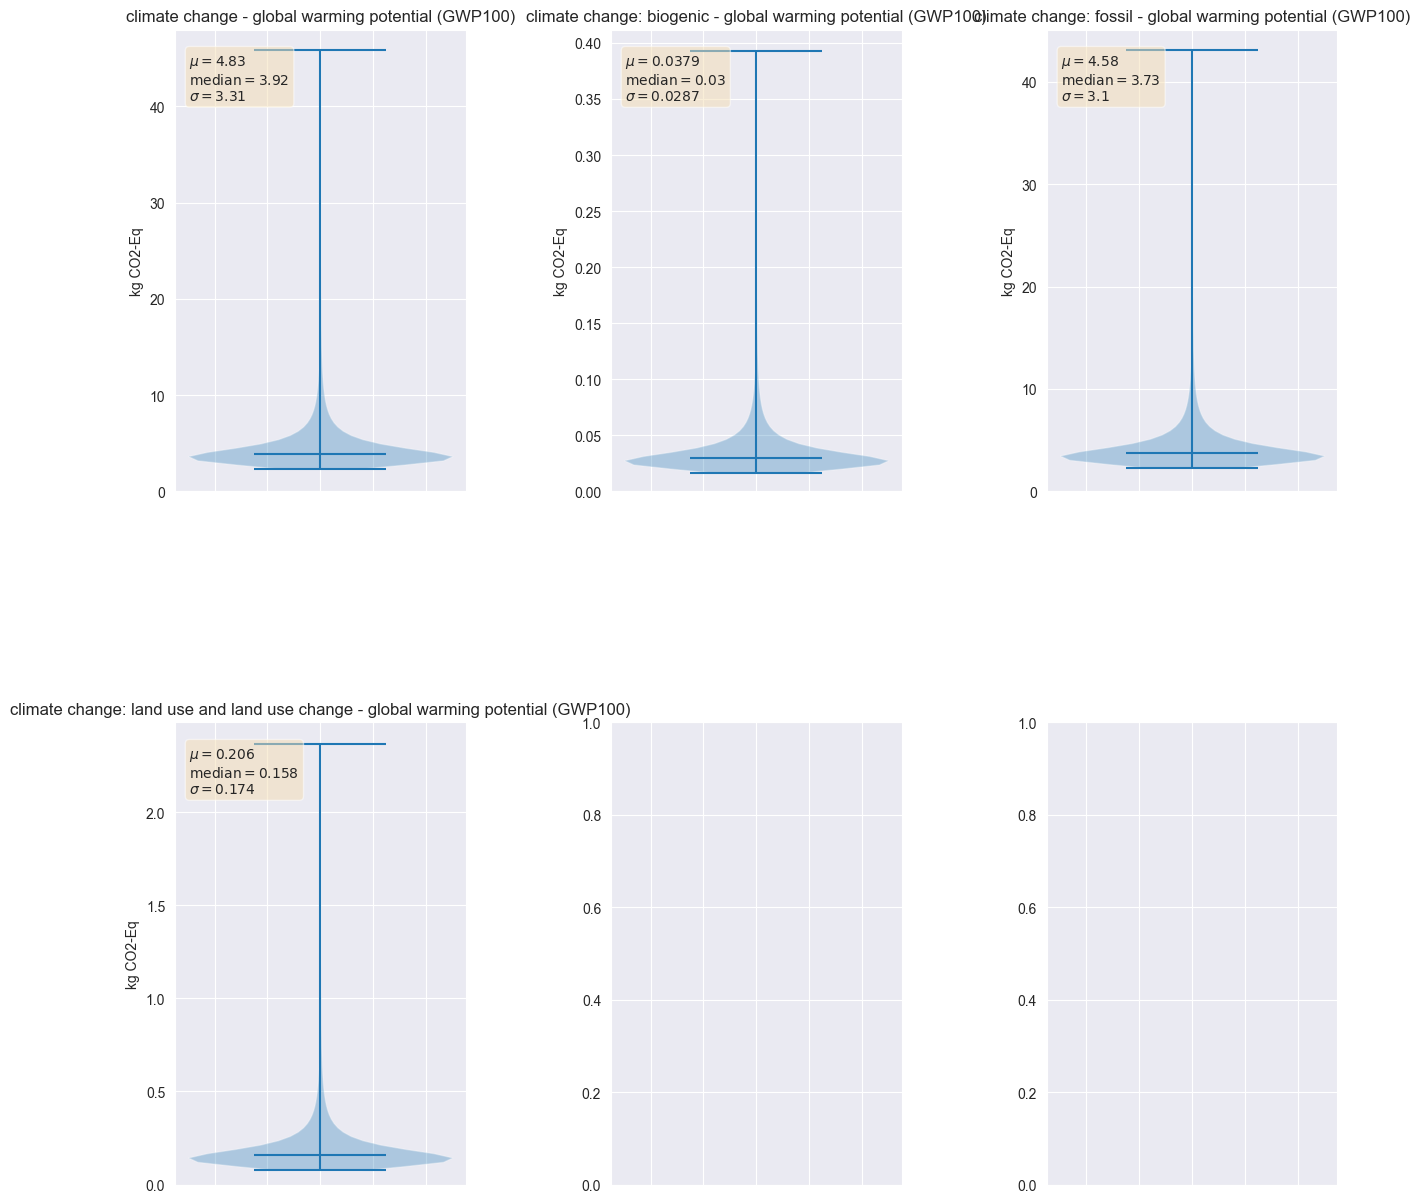

In [118]:
agb.incer_stochastic_violin(
    copper_p, impacts,
    functional_unit=functional_value,
    
    # Optionnal layout parameters
    figspace=(0.5,0.5),
    figsize=(15, 15),
    sharex=True, 
    nb_cols=3)

Generating samples ...
Transforming samples ...


,climate change - global warming potential (GWP100) [kg CO2-Eq / ],climate change: biogenic - global warming potential (GWP100) [kg CO2-Eq / ],climate change: fossil - global warming potential (GWP100) [kg CO2-Eq / ],climate change: land use and land use change - global warming potential (GWP100) [kg CO2-Eq / ]
median,3.91797,0.0299777,3.73026,0.157738
std,3.34128,0.0289577,3.1362,0.176125
p,"[2.8788166936958683, 9.495999210711673]","[0.02097173561243385, 0.07832048071371693]","[2.754882798829864, 8.96591381754066]","[0.10296215925356075, 0.451764912457285]"
mean,4.83017,0.0378834,4.58646,0.205821
var,0.691753,0.764391,0.683795,0.855717


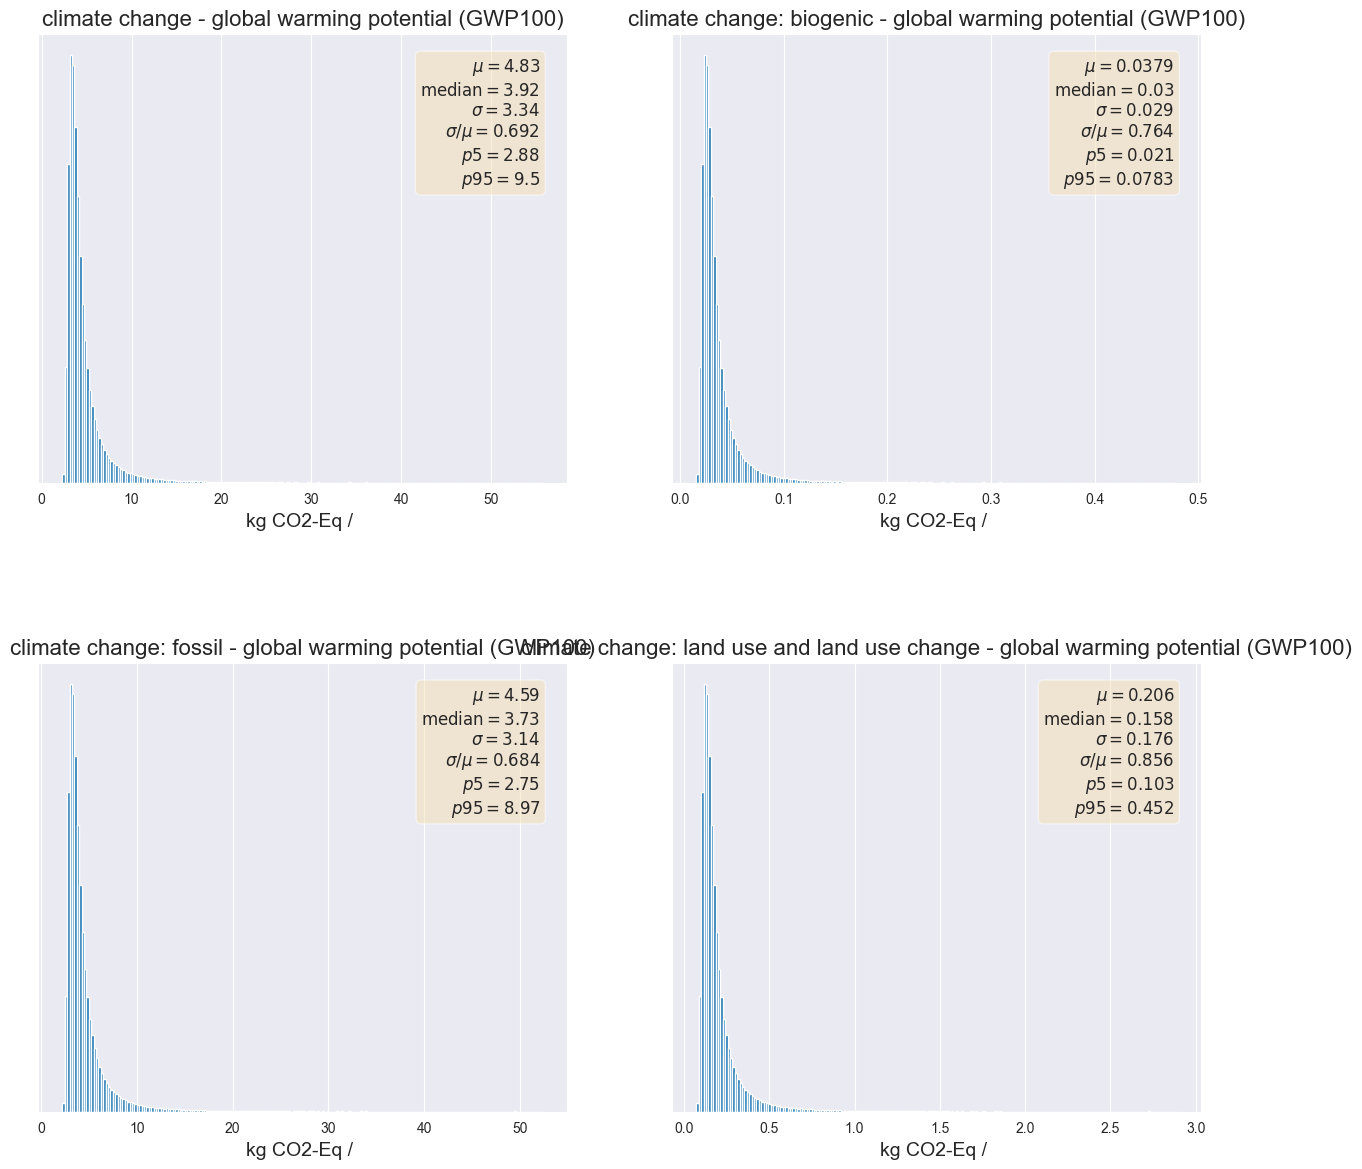

In [116]:
# Alternatively, graphs can be shown horizontally, together with a box of statistical outcomes
agb.distrib(
    copper_p, impacts,
    functional_unit=functional_value,
    
    # Optionnal layout parameters
    height=7, width=15,
    nb_cols=2,
    percentiles=[5, 95])

In [119]:
# Full dashboard, including total variation of impacts 
agb.incer_stochastic_dashboard(
    model=copper_p, 
    methods=impacts,
    functional_unit=functional_value)

Generating samples ...
Transforming samples ...
Processing Sobol indices ...
Processing sobol for ('EF v3.0', 'climate change', 'global warming potential (GWP100)')
Processing sobol for ('EF v3.0', 'climate change: biogenic', 'global warming potential (GWP100)')
Processing sobol for ('EF v3.0', 'climate change: fossil', 'global warming potential (GWP100)')
Processing sobol for ('EF v3.0', 'climate change: land use and land use change', 'global warming potential (GWP100)')


C:\Users\mp_ma\anaconda3\envs\lca\lib\site-packages\SALib\util\__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


# Simplified model

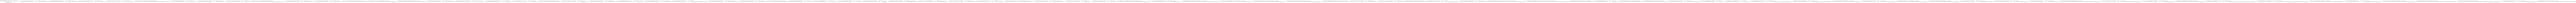

In [120]:
# First, let's look at the full expression defining our model
expr, _ = agb.actToExpression(copper_p)
expr

Generating samples ...
Transforming samples ...


C:\Users\mp_ma\anaconda3\envs\lca\lib\site-packages\scipy\stats\_qmc.py:958: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  sample = self._random(n, workers=workers)


Processing sobol for ('EF v3.0', 'climate change', 'global warming potential (GWP100)')


C:\Users\mp_ma\anaconda3\envs\lca\lib\site-packages\SALib\util\__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


Processing sobol for ('EF v3.0', 'climate change: biogenic', 'global warming potential (GWP100)')
Processing sobol for ('EF v3.0', 'climate change: fossil', 'global warming potential (GWP100)')
Processing sobol for ('EF v3.0', 'climate change: land use and land use change', 'global warming potential (GWP100)')
> Method :  climate change - global warming potential (GWP100)
S1:  1.0013450848937724
S2:  0.0029872507899479928
ST:  1.0028387102887466
Selected params :  ['ore_grade_copper'] explains:  1.0013450848937724


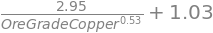

> Method :  climate change: biogenic - global warming potential (GWP100)
S1:  1.0013450848937722
S2:  0.002987250789948215
ST:  1.0028387102887464
Selected params :  ['ore_grade_copper'] explains:  1.0013450848937722


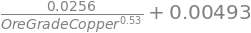

> Method :  climate change: fossil - global warming potential (GWP100)
S1:  1.0013450848937726
S2:  0.0029872507899479928
ST:  1.0028387102887468
Selected params :  ['ore_grade_copper'] explains:  1.0013450848937726


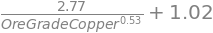

> Method :  climate change: land use and land use change - global warming potential (GWP100)
S1:  1.001345084893772
S2:  0.002987250789948215
ST:  1.0028387102887464
Selected params :  ['ore_grade_copper'] explains:  1.001345084893772


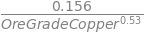

In [121]:
simplified = agb.sobol_simplify_model(
    copper_p, # The model
    impacts, # Impacts to consider
    functional_unit=functional_value,
    
    n=10000, # For large model, you may test other value and ensure ST and sum(S1) are close to 1.0 
    fixed_mode = agb.FixedParamMode.MEDIAN, # We replace minor parameters by median by default,
    min_ratio=0.8, # Min ratio of variability to explain
    num_digits=3)

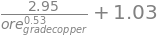

In [122]:
# Let's look at the expression for first impact again 
# much simpler ! 
simplified[0].expr

[INFO] Required param 'ore_grade_copper' was missing, replacing by default value : 0.834055
[INFO] Required param 'ore_grade_copper' was missing, replacing by default value : 0.834055


Generating samples ...
Transforming samples ...


C:\Users\mp_ma\anaconda3\envs\lca\lib\site-packages\lca_algebraic\stats.py:1349: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "R² : %0.3g" % r_value,
[INFO] Required param 'ore_grade_copper' was missing, replacing by default value : 0.834055
[INFO] Required param 'ore_grade_copper' was missing, replacing by default value : 0.834055


Generating samples ...
Transforming samples ...


C:\Users\mp_ma\anaconda3\envs\lca\lib\site-packages\lca_algebraic\stats.py:1349: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "R² : %0.3g" % r_value,
[INFO] Required param 'ore_grade_copper' was missing, replacing by default value : 0.834055
[INFO] Required param 'ore_grade_copper' was missing, replacing by default value : 0.834055


Generating samples ...
Transforming samples ...


C:\Users\mp_ma\anaconda3\envs\lca\lib\site-packages\lca_algebraic\stats.py:1349: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "R² : %0.3g" % r_value,
[INFO] Required param 'ore_grade_copper' was missing, replacing by default value : 0.834055
[INFO] Required param 'ore_grade_copper' was missing, replacing by default value : 0.834055


Generating samples ...
Transforming samples ...


C:\Users\mp_ma\anaconda3\envs\lca\lib\site-packages\lca_algebraic\stats.py:1349: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "R² : %0.3g" % r_value,


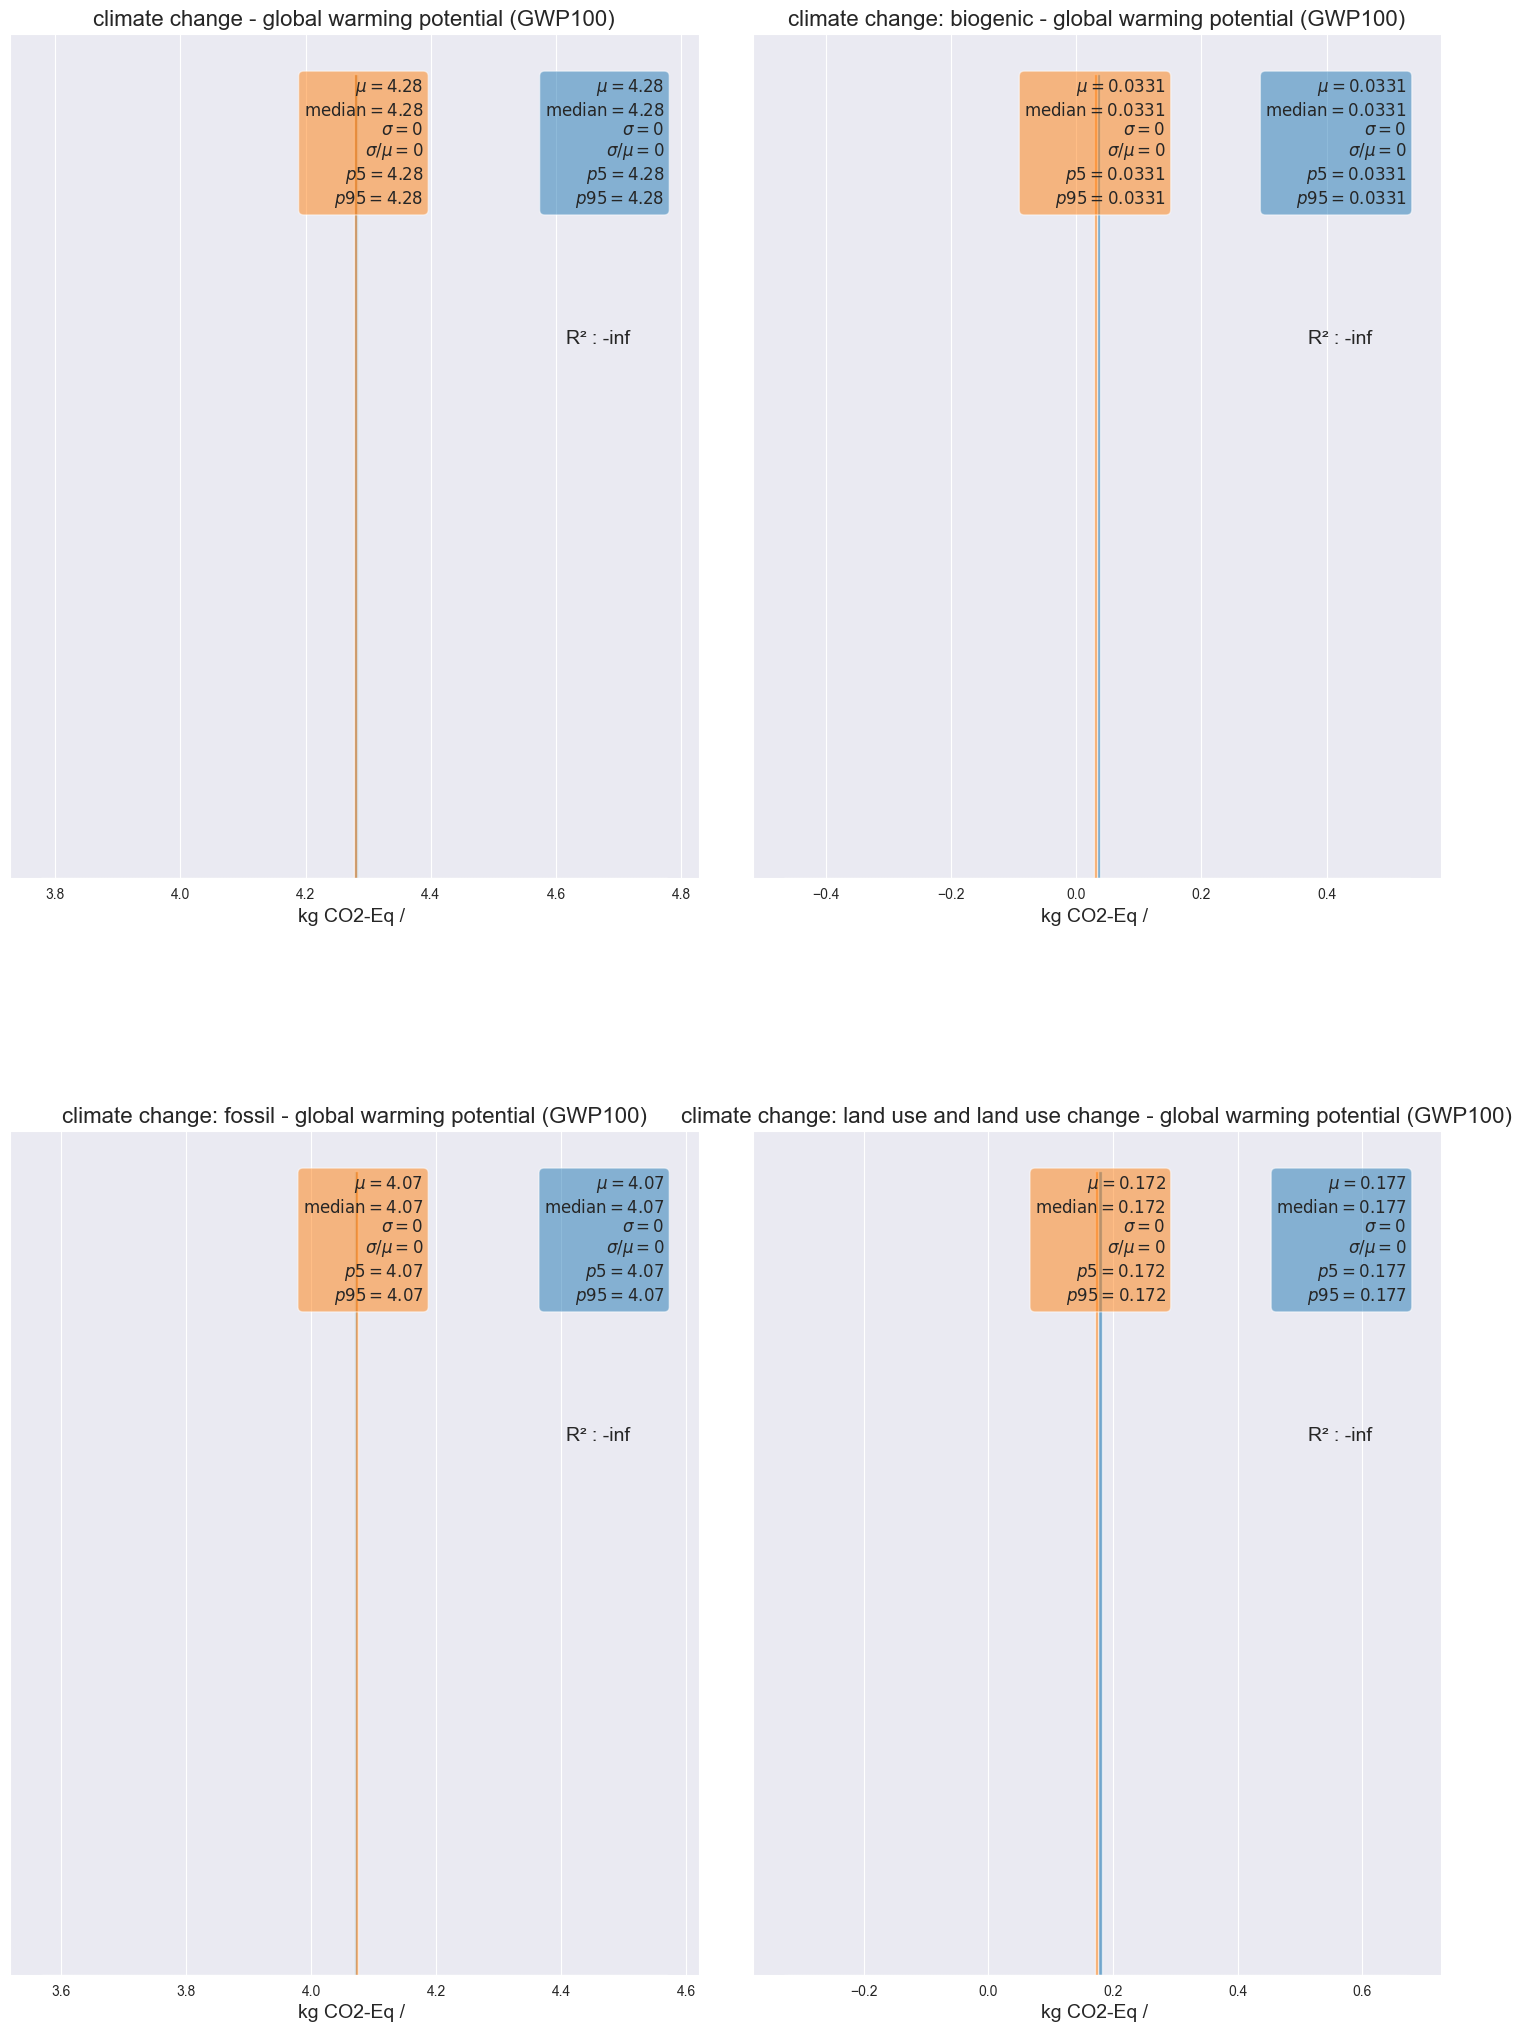

In [123]:
agb.compare_simplified(
    copper_p, 
    impacts, 
    simplified,
    functional_unit=functional_value)